In [1]:
# Connect to google drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import relevant libraries and setup matplotlib plot style
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib import image as img

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import os
import random
from PIL import Image
import sys
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [3]:
# Save the train and tests csv as train_csv and test_csv dataframes
train_csv = pd.read_csv("/content/drive/MyDrive/archive (8)/Human Action Recognition/Training_set.csv")
test_csv = pd.read_csv("/content/drive/MyDrive/archive (8)/Human Action Recognition/Testing_set.csv")

### Data Visualisation

In [4]:
train_csv

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop
...,...,...
12595,Image_12596.jpg,sitting
12596,Image_12597.jpg,clapping
12597,Image_12598.jpg,sitting
12598,Image_12599.jpg,dancing


In [5]:
test_csv

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg
...,...
5395,Image_5396.jpg
5396,Image_5397.jpg
5397,Image_5398.jpg
5398,Image_5399.jpg


In [6]:
# Visualise values of labels
train_csv.label.value_counts()

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64

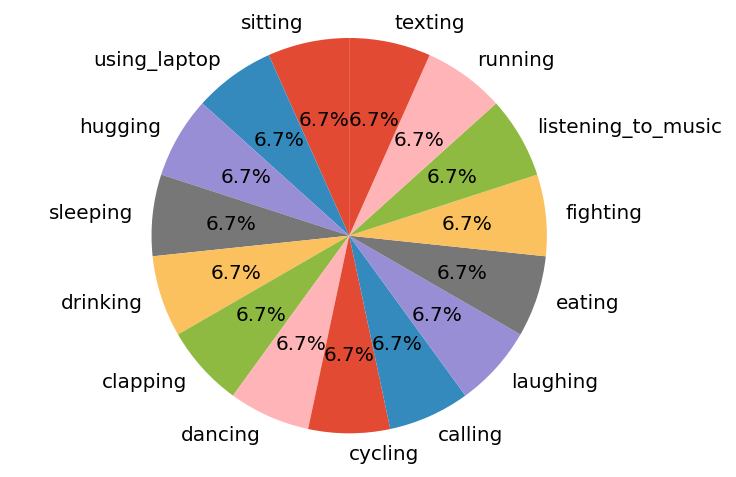

In [7]:
# Using pie chart to better visualise values of labels
fig1, ax1 = plt.subplots()
sizes = train_csv.label.value_counts()
labels = train_csv["label"].unique()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=90)
ax1.axis('equal')

plt.show()

In [8]:
# Visualise number of null values in train_csv
train_csv.isnull().sum()

filename    0
label       0
dtype: int64

There are no null values in train_csv

In [9]:
# Visualising datatypes of train_csv
train_csv.dtypes

filename    object
label       object
dtype: object

In [10]:
# Visualising the types of labels in train_csv
unique_vals = train_csv["label"].unique()
unique_vals

array(['sitting', 'using_laptop', 'hugging', 'sleeping', 'drinking',
       'clapping', 'dancing', 'cycling', 'calling', 'laughing', 'eating',
       'fighting', 'listening_to_music', 'running', 'texting'],
      dtype=object)

In [11]:
# Visualising number of unique labels in train_csv
len(unique_vals)

15

In [12]:
# Visualising shape of train_csv
train_csv.shape

(12600, 2)

In [13]:
# Visualising shape of test_csv
test_csv.shape

(5400, 1)

In [14]:
# Create function to display random images from train_csv together with their specific labels

def random_images(n=1):
    plt.figure(figsize=(15, 20))
    for i in range(n):
        rnd = random.randint(0, len(train_csv)-1)
        img_file = '/content/drive/MyDrive/archive (8)/Human Action Recognition/train/' + train_csv['filename'][rnd] # concatonating img to label

        if os.path.exists(img_file):
            plt.subplot(n//2+1, 2, i + 1)
            image = img.imread(img_file)
            plt.imshow(image)
            plt.title(train_csv['label'][rnd])

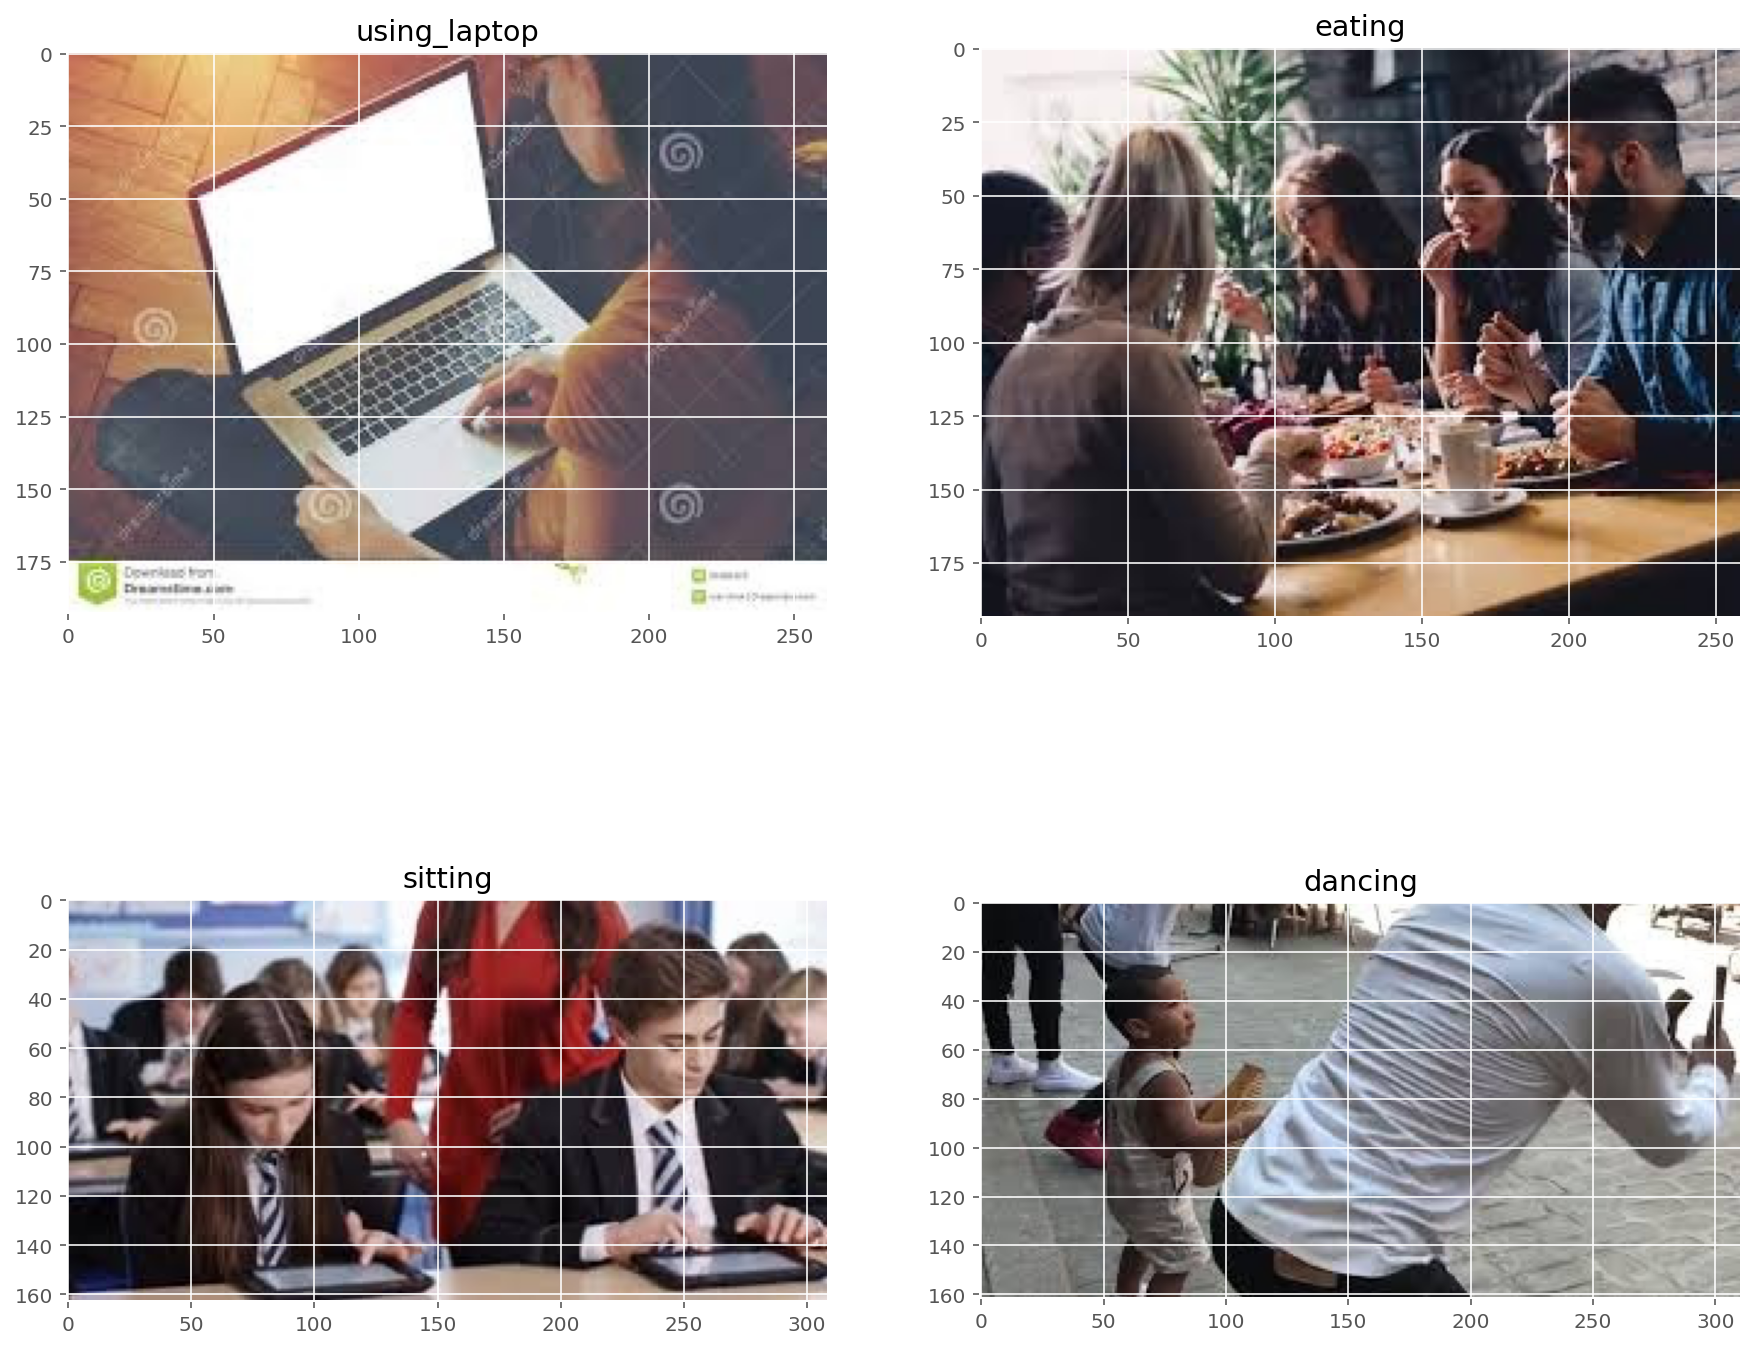

In [15]:
# Displaying 4 random images
random_images(4)

Images are of different sizes

### Data Preprocessing

In [16]:
# Using label binarizer to binarize label (multi-class labels are binarized to binary labels using transform)
labelbinarizer = LabelBinarizer()
# Set y as binarized label
y = labelbinarizer.fit_transform(train_csv['label'])
# Save different classes in variable
action_labels = labelbinarizer.classes_
print(action_labels)

['calling' 'clapping' 'cycling' 'dancing' 'drinking' 'eating' 'fighting'
 'hugging' 'laughing' 'listening_to_music' 'running' 'sitting' 'sleeping'
 'texting' 'using_laptop']


In [17]:
# Set x as filename
x = train_csv['filename'].values

In [18]:
# Using train test split with x as filename and y as binarized lable, with a random state of 88 and split between 80% training and 20% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=88)

In [19]:
# Storing img data in variable and reshaping them to a numpy array of dimensions (160,160)
img_data = []
for i in tqdm(range(len(x_train))):
    image = Image.open('/content/drive/MyDrive/archive (8)/Human Action Recognition/train/' + x_train[i])
    img_data.append(np.asarray(image.resize((160,160)))) 

  0%|          | 0/10080 [00:00<?, ?it/s]

### Baseline Model

In [20]:
# Creating the baseline model 

baseline_model = Sequential()

vgg_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(160,160,3), # set input shape as (160,160,3) as images were resized to numpy array of dimensions (160,160)
                   pooling='avg',classes=15, # set number of classes of 15 as there are 15 labels
                   weights='imagenet')

for layer in vgg_model.layers:
        layer.trainable=False

baseline_model.add(vgg_model)
baseline_model.add(Flatten())
baseline_model.add(Dense(512, activation='relu')) # ReLu chosen as activation function due to efficiency
baseline_model.add(Dense(15, activation='softmax')) # set number of classes of 15 as there are 15 labels and activation function as softmax as it is a multiclass classification
baseline_model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy']) # loss as categorical cross entropy as labels are binarized
baseline_model.summary()
baseline_model_logs = baseline_model.fit(np.asarray(img_data), y_train, epochs=20,validation_split = 0.1) # fit model using array of image_data and y_train, with 20 epochs and 10% as validation

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14,985,039
Trainable params: 270,351
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/20
284/284 [==============================] - 35s 91ms/step - loss: 2.4590 - accuracy: 0.3936 - v

In [21]:
baseline_model.save_weights("model.h5")

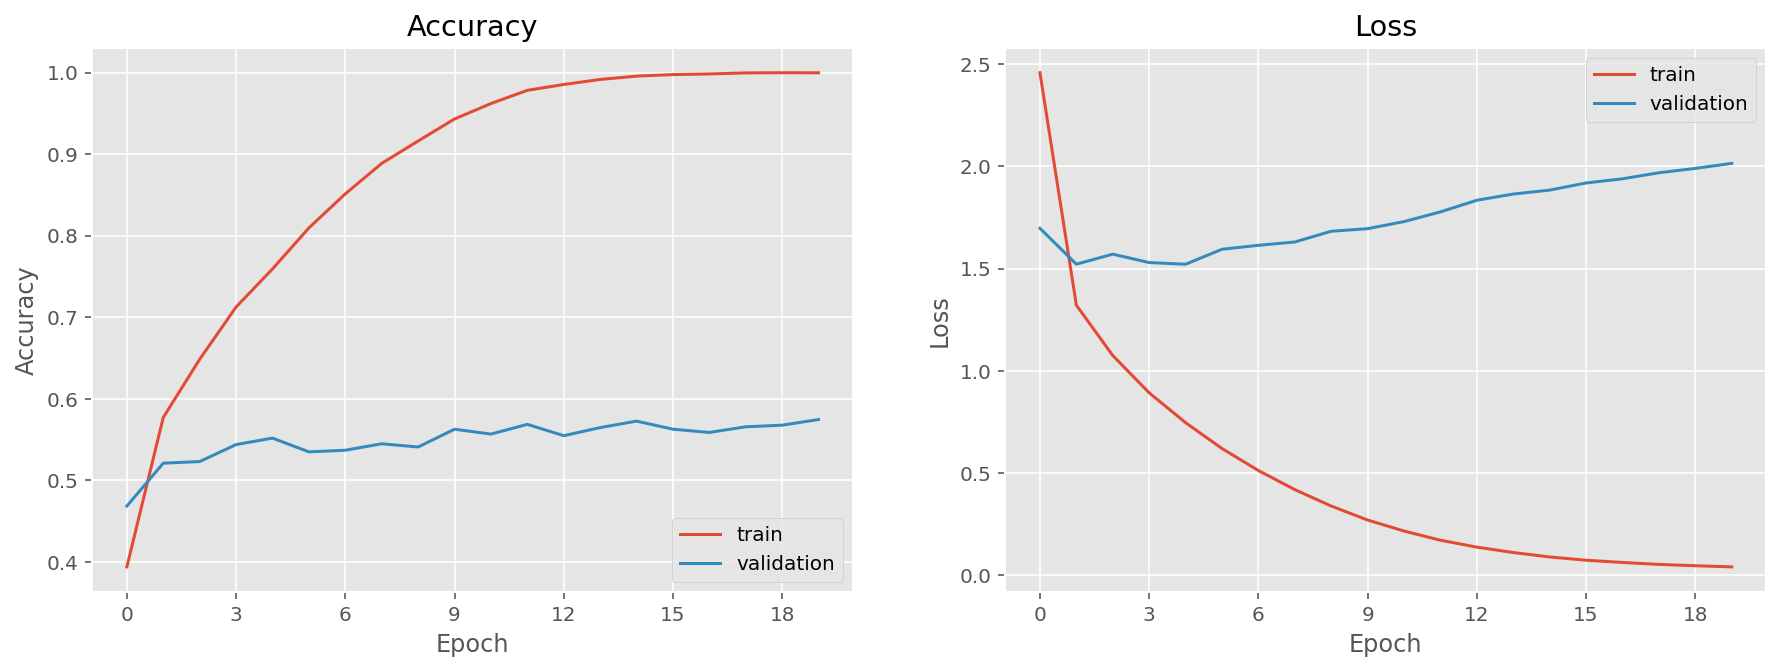

In [22]:
# Plot graph to visualise training and validation accuracy
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(baseline_model_logs.history['accuracy'])
ax1.plot(baseline_model_logs.history['val_accuracy'])
ax1.set_title('Accuracy')
ax1.set(xlabel='Epoch', ylabel= 'Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot graph to visualise training and validation loss
ax2.plot(baseline_model_logs.history['loss'])
ax2.plot(baseline_model_logs.history['val_loss'])
ax2.set_title('Loss')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [23]:
# Evaluating model's test loss and test accuracy
score = baseline_model.evaluate(np.asarray(img_data), y_train,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23087790608406067
Test accuracy: 0.9573412537574768


In [24]:
# Create a function to read the images as an array
def read_image(i):
    image = Image.open(i)
    return np.asarray(image.resize((160,160))) # Resize the images to dimensions (160,160)

In [25]:
# Create a function to predict images using the model
def human_action_prediction(human_action):
    result = baseline_model.predict(np.asarray([read_image(human_action)]))

    itemindex = np.where(result==np.max(result))
    predicted_value = action_labels[itemindex[1][0]]
    print("Probability of Action: "+str(np.max(result)*100) + "%\nPredicted Human Action : ", predicted_value)

    image = img.imread(human_action)
    plt.imshow(image)
    plt.title(predicted_value)

1/1 [==============================] - 1s 692ms/step
Probability of Action: 100.0%
Predicted Human Action :  laughing


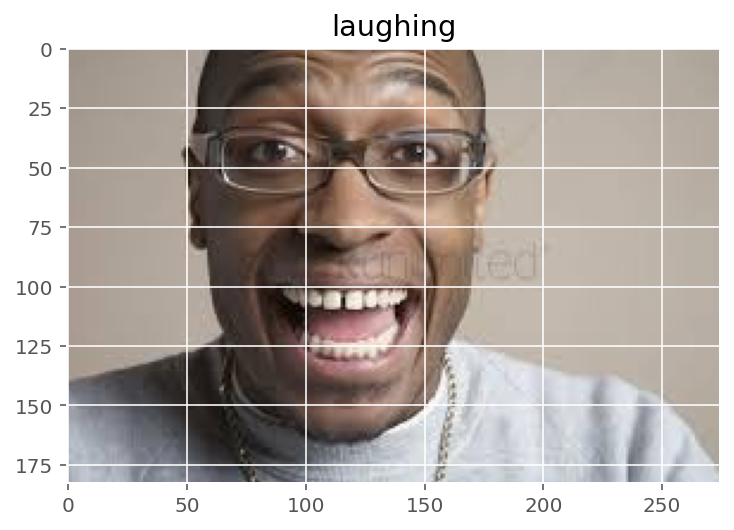

In [26]:
# Testing model by predicting images
human_action_prediction('/content/drive/MyDrive/archive (8)/Human Action Recognition/test/Image_68.jpg')

1/1 [==============================] - 0s 18ms/step
Probability of Action: 96.41687870025635%
Predicted Human Action :  eating


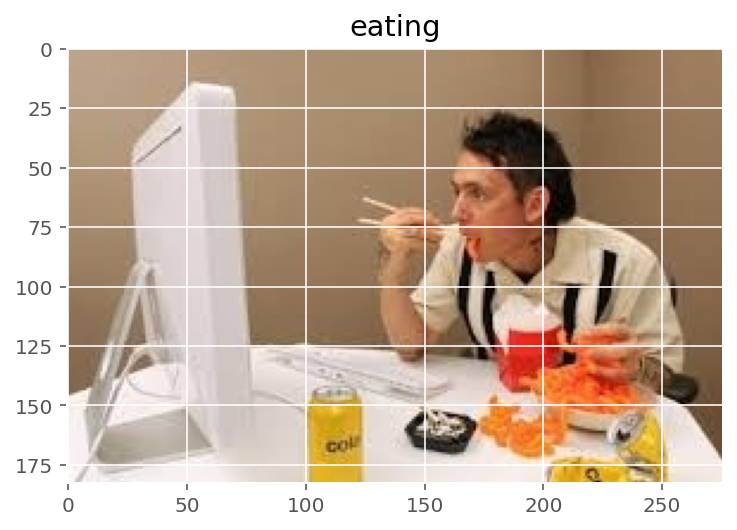

In [27]:
# Testing model by predicting images
human_action_prediction('/content/drive/MyDrive/archive (8)/Human Action Recognition/test/Image_3195.jpg')

1/1 [==============================] - 0s 16ms/step
Probability of Action: 99.3594229221344%
Predicted Human Action :  using_laptop


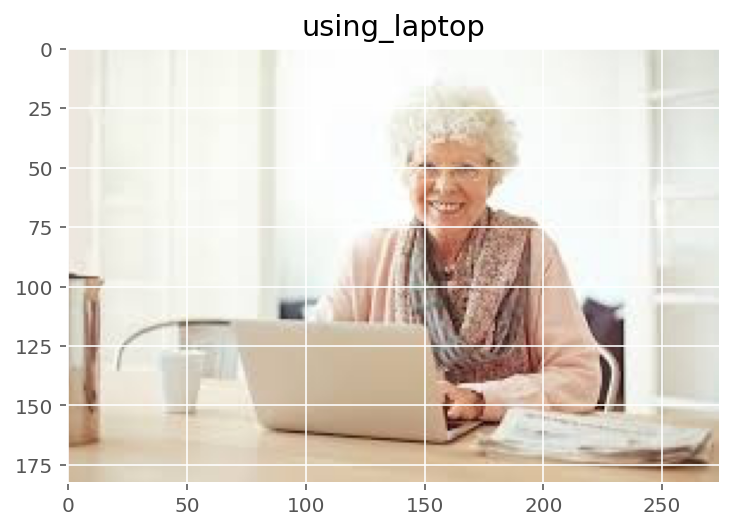

In [28]:
# Testing model by predicting images
human_action_prediction('/content/drive/MyDrive/archive (8)/Human Action Recognition/test/Image_5212.jpg')

1/1 [==============================] - 0s 15ms/step
Probability of Action: 77.411550283432%
Predicted Human Action :  sitting


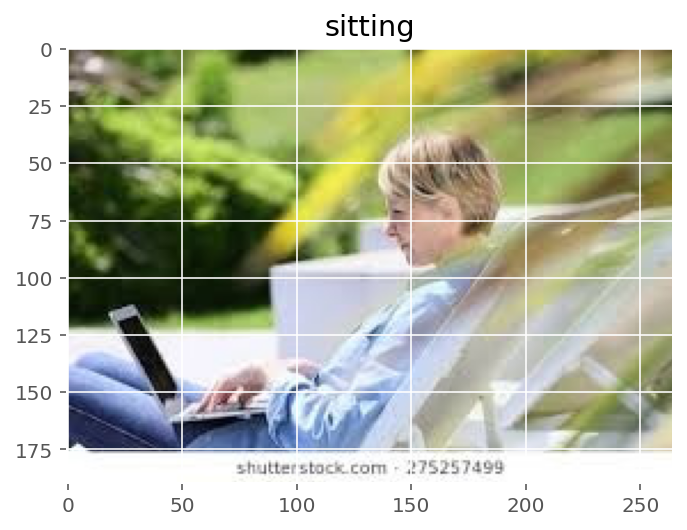

In [29]:
# Testing model by predicting images
human_action_prediction('/content/drive/MyDrive/archive (8)/Human Action Recognition/test/Image_1644.jpg')